In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
beta = 100. # inverse temperature
t = 1. # energy scale for cubic lattice
D = 1. # energy scale for bethe lattice

In [3]:
#definition of FourierTransforms
def matsubara_fft(G_tau):
    N = G_tau.shape[0]
    k = np.arange(N, dtype='float')
    return beta/N*np.fft.fft(G_tau*np.exp(1j*np.pi*k/N))
def matsubara_fft_trick(G_tau):
    N = G_tau.shape[0]
    freq = matsubara_freq(N)
    k = np.arange(N, dtype='float')
    return beta/N*np.fft.fft( (G_tau+0.5) *np.exp(1j*np.pi*k/N)) + 1./(1j*freq)
#numpy orders frequencies differently so one has to convert frequencies
def matsubara_freq(N):
    return np.pi/beta *( np.array(-2*N*np.fft.fftfreq(N),dtype=np.float128) +1.)
def matsubara_ifft(G_omega):
    N = G_omega.shape[0]
    k = np.arange(N,dtype='float')
    return N/beta*np.exp(-1j*np.pi*k/N)*np.fft.ifft(G_omega)
#following has to be improved:
def matsubara_ifft_trick(G_omega):
    N = G_omega.shape[0]
    freq = matsubara_freq(N)
    k = np.arange(N,dtype='float')
    return -1/2+N/beta*np.exp(-1j*np.pi*k/N)*np.fft.ifft(G_omega-1./(1j*freq) )

In [4]:
N = 500 # number of imaginary frequencies
tau = linspace(0,beta*(1.-1./N),N) # discrete points in imaginary time
dtau = beta/N
freq = matsubara_freq(N) # matsubara frequencies, ordered according to np.fft

In [5]:
# second order self energy diagram
def self_energy(G0_omega,U):
    G0_tau = matsubara_ifft_trick(G0_omega)
    G0_minus_tau = -np.roll(G0_tau[::-1],1)
    G0_minus_tau[0] = -G0_minus_tau[0]
    sigma_tau = -U*U * G0_tau*G0_tau * G0_minus_tau
    return matsubara_fft_trick(sigma_tau)

In [6]:
# compute local Green's function from self energy given a disperion / density of states
from scipy.integrate import simps
Ne = N
#Nk = N
#k = linspace(-np.pi,np.pi, Nk)
#epsilon_k = -2.*t*np.cos(k)
def dos_bethe(e):
    return 2./(np.pi*D)*np.sqrt(1.-(e/D)**2)
def dos_cubic(e):
    return 1./(t*np.sqrt(2.*np.pi))*np.exp(-e**2/(2.*t))
def Gloc_omega(self_energy_omega):
    #return 1./Nk*np.sum(1./(1j*freq-epsilon_k[:, np.newaxis]-self_energy_omega),axis=0)
    ##
    energies_bethe = np.linspace(-D,D,Ne)
    denergies_bethe = energies_bethe[2] - energies_bethe[1]
    return simps( dos_bethe(energies_bethe)/(1j*freq[:,np.newaxis]-energies_bethe-self_energy_omega[:,np.newaxis]) ,dx=denergies_bethe)
    ##
    #energies_cubic = np.linspace(-10.*t,10*t,Ne)
    #denergies_cubic = energies_cubic[2] - energies_cubic[1]
    #return simps( dos_cubic(energies_cubic)/(1j*freq[:,np.newaxis]-energies_cubic-self_energy_omega[:,np.newaxis]) ,dx=denergies_cubic)

In [7]:
# perform one loop from G0_initial to get new G0 and Gloc
def DMFT_loop(G0_initial_omega,U,frac_new):
    G0_omega= G0_initial_omega
    self_e = self_energy(G0_omega,U)
    Gloc = Gloc_omega(self_e)
    #G0_omega = frac_new * 1./(1./Gloc+self_e) + (1.-frac_new) * G0_omega
    G0_omega = frac_new/( 1j*freq - 0.25*D*D* Gloc ) + (1.-frac_new) * G0_omega # only for Bethe lattice
    return G0_omega, Gloc

In [8]:
# use the Padé approximation to interpolate the Green's function
def get_a(points,values,regularizing_amplitude=1e-15,seed=23):  
    n = points.shape[0]
    g_matrix = np.zeros((n,n),dtype=np.complex256)
    #np.random.seed(seed)
    #g_matrix[1:,:] = regularizing_amplitude* ( (2.*np.random.rand(n-1,n)-1.) + 1j*(2.*np.random.rand(n-1,n)-1.) )
    g_matrix[0] = values
    for i in range(1,n):
        g_matrix[i,i:] = ( g_matrix[i-1,i-1] - g_matrix[i-1,i:] ) / ( ( points[i:] - points[i-1] ) * g_matrix[i-1,i:] )
        #g_matrix[i,i:] = ( g_matrix[i-1,i-1] - g_matrix[i-1,i:] ) / ( ( points[i:] - points[i-1] ) * g_matrix[i-1,i:] ) + regularizing_amplitude* ( (2.*np.random.rand(1)[0]-1.) + 1j*(2.*np.random.rand(1)[0]-1.) )
    return g_matrix.diagonal()
def get_C(z,points,a_coeff):
    Na = points.size
    Nz = z.size
    A = np.zeros((Na+1,Nz),dtype=np.complex256)
    B = np.zeros((Na+1,Nz),dtype=np.complex256)
    A[1] = a_coeff[0]
    B[0] = 1.
    B[1] = 1.
    for i in range(2,Na+1):
        A[i] = A[i-1] + (z-points[i-2]) * a_coeff[i-1] * A[i-2]
        B[i] = B[i-1] + (z-points[i-2]) * a_coeff[i-1] * B[i-2]
    return A[Na]/B[Na]

In [19]:
# fit various Green's functions and plot the spectral function
G0 = 1. / ( 1j*freq + 2. )
g_0 = G0
Glocs = []
U_list = np.array([0.2,0.6,1.,1.45,1.9])
numiter = 100
for U in U_list:
    for i in range(numiter):
        g_0, g_loc = DMFT_loop(g_0,U,0.7)
    Glocs.append(g_loc)

In [10]:
def shift_cut_symmetric(array, lower,upper,k):
    n = array.size
    interstep = 2*k+1
    a1 = np.fft.fftshift(array)[n/2+k+1:upper:interstep]
    a2 = np.fft.fftshift(array)[n/2-k:lower:-interstep]
    return np.concatenate((a2,a1))

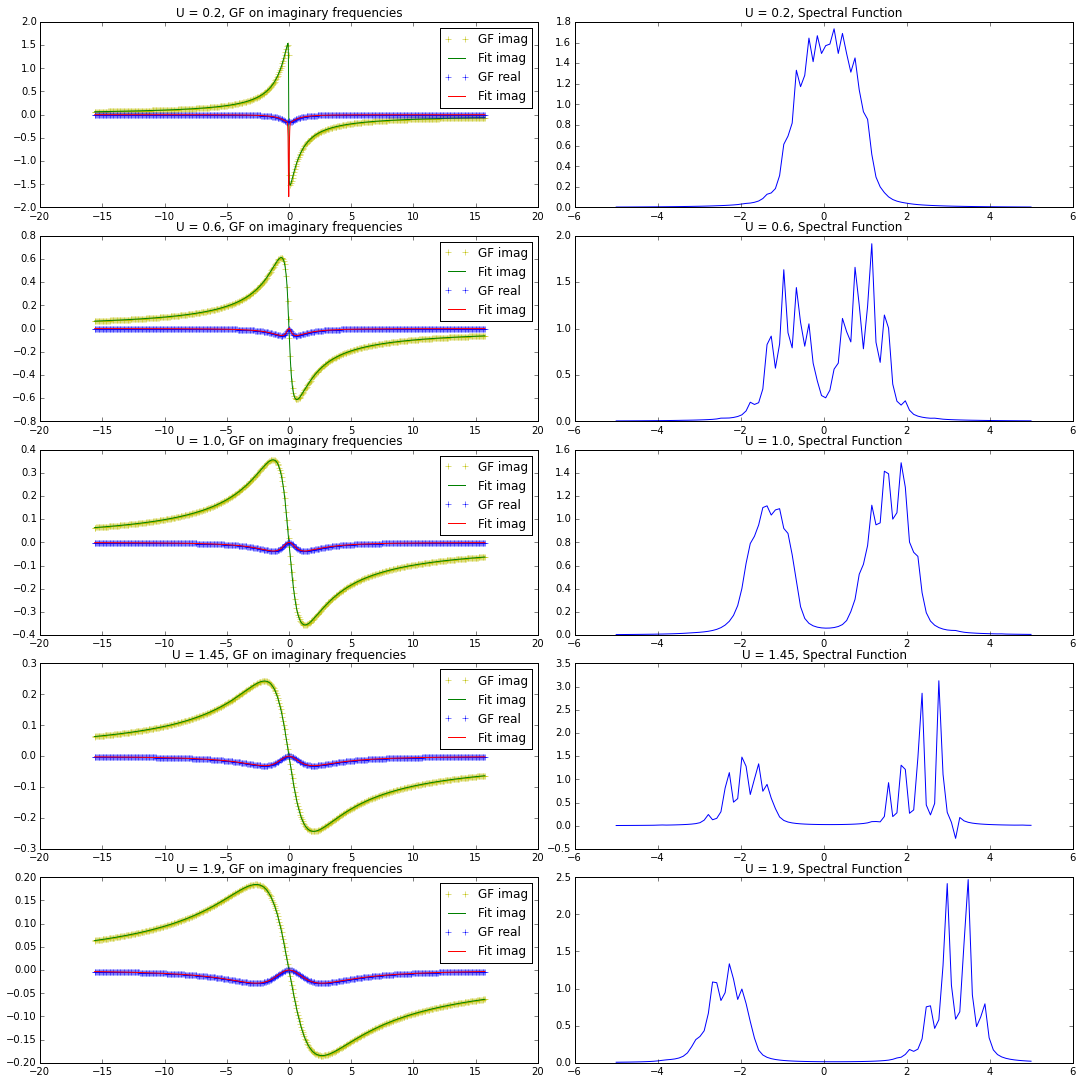

In [20]:
#step = 160
cut = 0.1
k = 2
#interstep = 2*k+1
eta = 0.1
plot_freq = np.linspace(-5.,5.,100)
my_freq = eta - 1j*plot_freq
#gf = 1./(1j*freq+2.)
fig, ax = plt.subplots(nrows=len(Glocs),ncols=2,figsize=(15,15))
fig.tight_layout()
for index in range(len(Glocs)):
    gf = Glocs[index]
    n = freq.size
    lower = int(cut*n)
    upper = int((1.-cut)*n)
    freq_points = shift_cut_symmetric(freq,lower,upper,k)
    gf_points = shift_cut_symmetric(gf,lower,upper,k)
    # freq_points = freq[::step]
    #freq_points = np.fft.fftshift(freq)[lower:upper:interstep]
    # gf_points = gf[::step]
    #gf_points = np.fft.fftshift(gf)[lower:upper:interstep]
    a_list = get_a(freq_points, gf_points,1e-15,23)
    spectral_func = -get_C(my_freq,freq_points,a_list).imag
    ordered_mats_freq = np.fft.fftshift(freq)
    fit_plot_freq = np.linspace(ordered_mats_freq[0],ordered_mats_freq[-1],5000)
    fit_func = get_C(fit_plot_freq,freq_points,a_list)
    ax[index,0].set_title("U = {}, GF on imaginary frequencies".format(U_list[index]))
    ax[index,0].plot(freq,Glocs[index].imag,'y+',label="GF imag")
    ax[index,0].plot(fit_plot_freq,fit_func.imag,'g-',label="Fit imag")
    ax[index,0].plot(freq,Glocs[index].real,'b+',label="GF real")
    ax[index,0].plot(fit_plot_freq,fit_func.real,'r-',label="Fit imag")
    ax[index,0].legend()  
    ax[index,1].set_title("U = {}, Spectral Function".format(U_list[index]))
    ax[index,1].plot(plot_freq,spectral_func,'-')